In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download delayedkarma/impressionist-classifier-data
! unzip impressionist-classifier-data.zip

100% 2.18G/2.19G [01:52<00:00, 20.7MB/s]
100% 2.19G/2.19G [01:52<00:00, 20.8MB/s]
Archive:  impressionist-classifier-data.zip
  inflating: training/training/Cezanne/215457.jpg  
  inflating: training/training/Cezanne/215458.jpg  
  inflating: training/training/Cezanne/215459.jpg  
  inflating: training/training/Cezanne/215460.jpg  
  inflating: training/training/Cezanne/215462.jpg  
  inflating: training/training/Cezanne/215463.jpg  
  inflating: training/training/Cezanne/215466.jpg  
  inflating: training/training/Cezanne/215467.jpg  
  inflating: training/training/Cezanne/215468.jpg  
  inflating: training/training/Cezanne/215469.jpg  
  inflating: training/training/Cezanne/215470.jpg  
  inflating: training/training/Cezanne/215471.jpg  
  inflating: training/training/Cezanne/215473.jpg  
  inflating: training/training/Cezanne/215474.jpg  
  inflating: training/training/Cezanne/215475.jpg  
  inflating: training/training/Cezanne/215476.jpg  
  inflating: training/training/Cezanne/215

In [ ]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import Generator
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools
import time
import copy
from torchvision.models import ResNet50_Weights
from torch.nn import Module
from torchvision import models
import torch.optim as optim
import seaborn as sns
import torchvision
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [ ]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 6050
setup_seed(SEED)

In [ ]:
artists = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
artists = os.listdir('training/training')

In [ ]:
transformation = Compose([
    Resize((256,256)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [ ]:
for artist in artists:
    exec(f"train_{artist}_dir = os.path.join('training/training', '{artist}')")
    exec(f"train_{artist}_filenames = os.listdir(train_{artist}_dir)")
    exec(f"valid_{artist}_dir = os.path.join('validation/validation', '{artist}')")
    exec(f"valid_{artist}_filenames = os.listdir(valid_{artist}_dir)")

In [ ]:
# https://www.kaggle.com/code/delayedkarma/display-impressionist-images

def plot_imgs(artist, nrows=1, ncols=4, num_imgs=4):
    """
    Function to plot random sample images for each artist in a num_rows x num_cols grid
    :param artist: Artist name
    :type artist: str
    :param nrows: Number of rows in grid
    :type nrows: int
    :param ncols: Number of columns
    :type ncols: int
    :param num_imgs: Number of sample images to plot
    :type num_imgs: int
    :return: None
    """
    
    pic_idx = 0
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 6, nrows * 6)

    pic_idx += num_imgs

    train_dir = eval(f"train_{artist}_dir")
    filenames = eval(f"train_{artist}_filenames")
    filenames = random.sample(filenames, len(filenames))
    
    next_pix = [os.path.join(train_dir, fname) 
                    for fname in filenames[pic_idx-num_imgs: pic_idx]]


    for i, img_path in enumerate(next_pix):
        plt.suptitle(f"{artist}", fontsize=24)
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        img = mpimg.imread(img_path)
        plt.imshow(img)

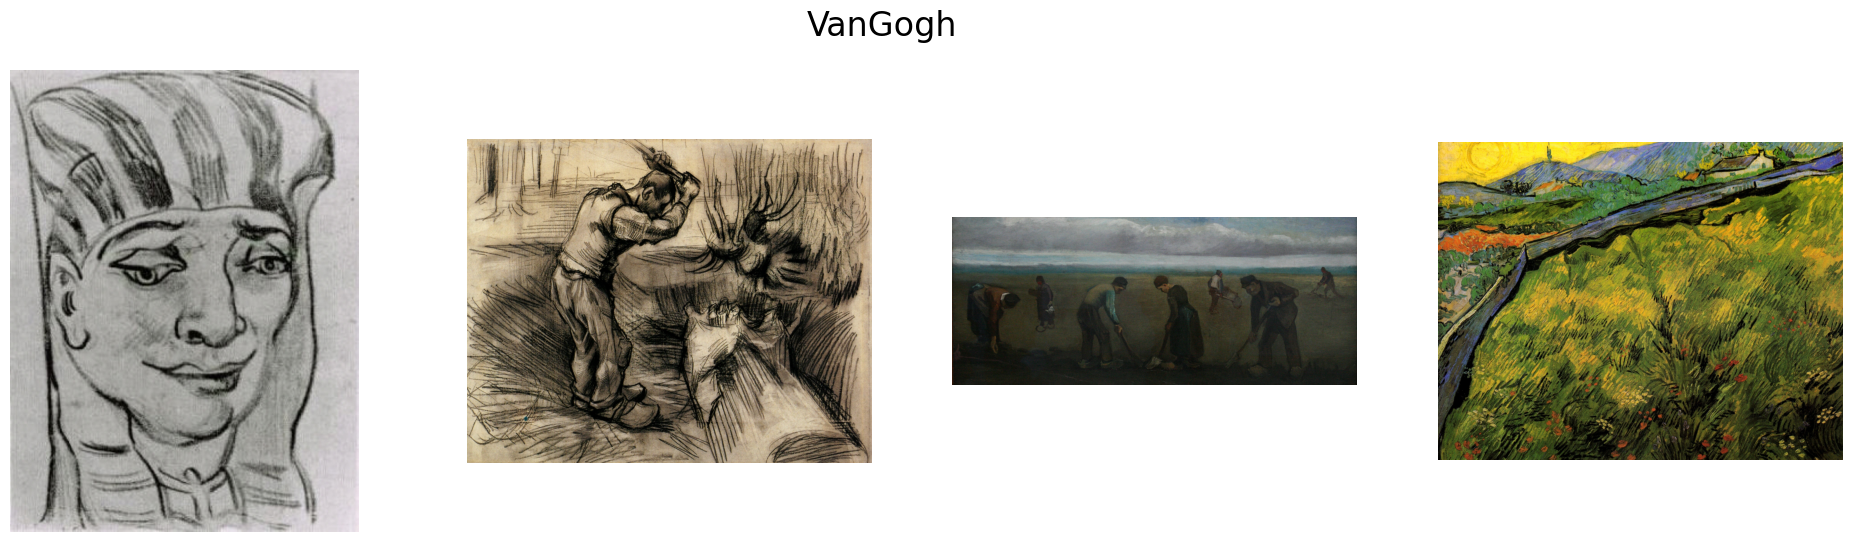

In [ ]:
plot_imgs(artists[0])

In [ ]:
# define the model training function
def train_model(model, criterion, optimizer, num_epochs=25):
    # initialize the start time
    since = time.time()

    # initialize the best weight configuration and accuracy of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # initialize the lists that will store the accuracies and losses across the epochs
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    # iterate over the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # initialize the running losses and corrects
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass
                    # optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # calculate and update epoch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print epoch performance statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store epoch performance statistics
            if phase == 'training':
              train_accs.append(epoch_acc.item())
              train_losses.append(epoch_loss)
            else:
              val_accs.append(epoch_acc.item())
              val_losses.append(epoch_loss)

            # deep copy the model to reflect the best weight configuration
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # print the training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses

In [ ]:
!pip install googlenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
global_LR = 5e-4
global_WD = 1e-5
global_DR = 0.0

## Model 1: Pre-trained GoogLeNet (36 mins)
- batch_size= 32
- lr = 5e-4
- WD = 1e-5
- Data Augmentation

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")
model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 84.0MB/s]


Loaded pretrained weights for googlenet


In [ ]:
# define the loss function
criterion_1 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the fully connected head
optimizer_1 = optim.Adam(model_google.parameters(), lr=global_LR)

In [ ]:
# # train the model for the desired number of epochs
# model_1, train_accs_1, train_losses_1, val_accs_1, val_losses_1 = train_model(model_google, criterion_1, optimizer_1, num_epochs=10)

In [ ]:
# data_acc_1 = pd.DataFrame({"Train Accuracy": train_accs_1, "Val Accuracy": val_accs_1})
# data_loss_1 = pd.DataFrame({"Train Loss": train_losses_1, "Val Loss": val_losses_1})

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plt.suptitle("Accuracy and Loss of Model 1 Across Epochs")

# sns.lineplot(data=data_acc_1, ax = axs[0])
# axs[0].set_title("Accuracy")


# sns.lineplot(data=data_loss_1, ax = axs[1])
# axs[1].set_title("Loss")

In [ ]:
# result_1 = pd.concat([data_acc_1, data_loss_1], axis = 1)
# result_1

In [ ]:
# result_1.to_csv("result_1.csv")

In [ ]:
# with open('/content/drive/My Drive/filename.extension', 'w') as f:
#   # f.write("result_1.csv")

## Model 2

- batch_size= 16
- lr = 5e-4
- WD = 1e-5
- DR = 0
- Data Augmentation

In [ ]:
BS = 16
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_2 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 5e-4

# EDIT WEIGHT DECAY (L2 REGULARIZATION) HERE (tune 1e-5, 1e-4, 1e-3)
WD = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_2 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
# # train the model for the desired number of epochs
model_2, train_accs_2, train_losses_2, val_accs_2, val_losses_2 = train_model(model_google, criterion_2, optimizer_2, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.3298 Acc: 0.5682
validation Loss: 0.9061 Acc: 0.6990

Epoch 2/10
----------
training Loss: 0.9134 Acc: 0.7104
validation Loss: 0.7097 Acc: 0.7596

Epoch 3/10
----------
training Loss: 0.7730 Acc: 0.7535
validation Loss: 0.7267 Acc: 0.7556

Epoch 4/10
----------
training Loss: 0.6563 Acc: 0.7861
validation Loss: 0.6406 Acc: 0.8040

Epoch 5/10
----------
training Loss: 0.6166 Acc: 0.7984
validation Loss: 0.6424 Acc: 0.7980

Epoch 6/10
----------
training Loss: 0.5130 Acc: 0.8348
validation Loss: 0.6895 Acc: 0.7778

Epoch 7/10
----------
training Loss: 0.4783 Acc: 0.8465
validation Loss: 0.5981 Acc: 0.8121

Epoch 8/10
----------
training Loss: 0.4155 Acc: 0.8636
validation Loss: 0.6868 Acc: 0.7838

Epoch 9/10
----------
training Loss: 0.3753 Acc: 0.8731
validation Loss: 0.6336 Acc: 0.8000

Epoch 10/10
----------
training Loss: 0.3401 Acc: 0.8874
validation Loss: 0.5965 Acc: 0.8182

Training complete in 34m 15s
Best val Acc: 0.818182


Text(0.5, 1.0, 'Loss')

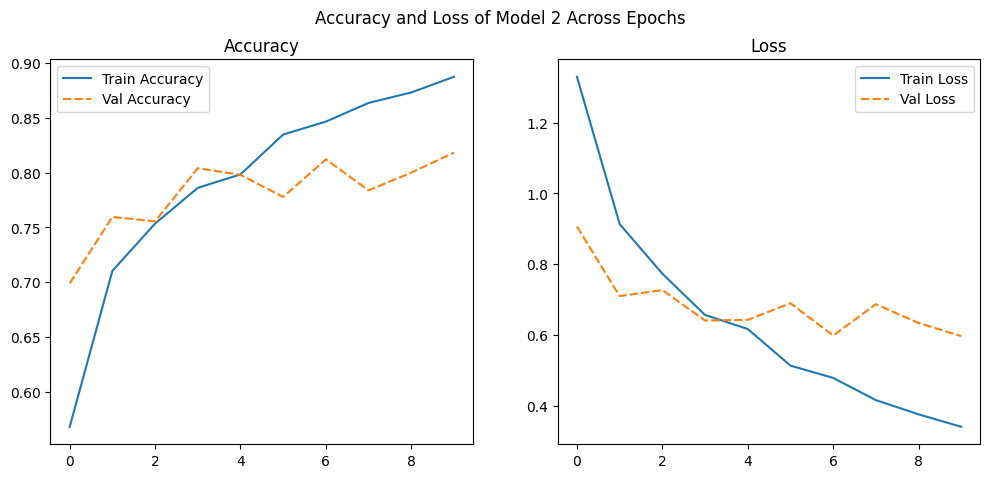

In [ ]:
data_acc_2 = pd.DataFrame({"Train Accuracy": train_accs_2, "Val Accuracy": val_accs_2})
data_loss_2 = pd.DataFrame({"Train Loss": train_losses_2, "Val Loss": val_losses_2})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 2 Across Epochs")

sns.lineplot(data=data_acc_2, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_2, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_2 = pd.concat([data_acc_2, data_loss_2], axis = 1)
result_2

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.568205,0.698990,1.329841,0.906118
1,0.710381,0.759596,0.913407,0.709680
2,0.753511,0.755556,0.773048,0.726712
3,0.786108,0.804040,0.656288,0.640581
4,0.798395,0.797980,0.616612,0.642383
5,0.834754,0.777778,0.513018,0.689452
6,0.846540,0.812121,0.478253,0.598071
7,0.863591,0.783838,0.415511,0.686758
8,0.873119,0.800000,0.375325,0.633558
9,0.887412,0.818182,0.340127,0.596516


In [ ]:
result_2.to_csv("result_2.csv")

In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_2.csv")

In [ ]:
# model_save_name = 'googlenet_final.pt'
# path = f"/content/drive/MyDrive/{model_save_name}" 
# torch.save(model_google.state_dict(), path)

## Model 3 --- OPTIMAL MODEL

- batch_size= 32
- lr = 5e-4
- WD = 1e-5
- DR = 0
- Data Augmentation

In [ ]:
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_3 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_3 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=global_WD)

In [ ]:
model_3, train_accs_3, train_losses_3, val_accs_3, val_losses_3 = train_model(model_google, criterion_3, optimizer_3, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.3169 Acc: 0.5853
validation Loss: 0.9421 Acc: 0.7071

Epoch 2/10
----------
training Loss: 0.8217 Acc: 0.7422
validation Loss: 0.7559 Acc: 0.7636

Epoch 3/10
----------
training Loss: 0.6607 Acc: 0.7971
validation Loss: 0.6837 Acc: 0.7899

Epoch 4/10
----------
training Loss: 0.5199 Acc: 0.8358
validation Loss: 0.7347 Acc: 0.7737

Epoch 5/10
----------
training Loss: 0.4643 Acc: 0.8490
validation Loss: 0.6809 Acc: 0.7737

Epoch 6/10
----------
training Loss: 0.3970 Acc: 0.8706
validation Loss: 0.6225 Acc: 0.8020

Epoch 7/10
----------
training Loss: 0.3332 Acc: 0.8952
validation Loss: 0.6016 Acc: 0.8364

Epoch 8/10
----------
training Loss: 0.2834 Acc: 0.9082
validation Loss: 0.6938 Acc: 0.7939

Epoch 9/10
----------
training Loss: 0.2714 Acc: 0.9140
validation Loss: 0.6752 Acc: 0.7899

Epoch 10/10
----------
training Loss: 0.2226 Acc: 0.9323
validation Loss: 0.7159 Acc: 0.7980

Training complete in 34m 1s
Best val Acc: 0.836364


Text(0.5, 1.0, 'Loss')

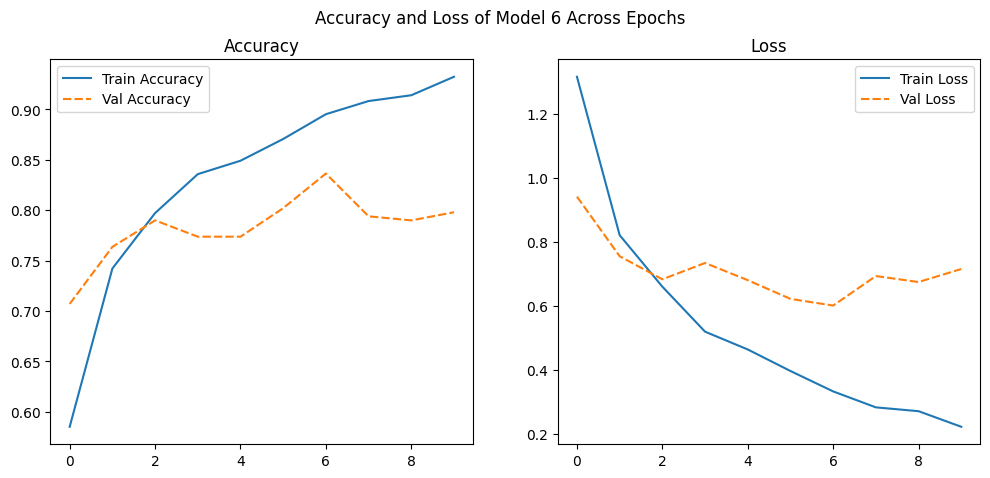

In [ ]:
data_acc_6 = pd.DataFrame({"Train Accuracy": train_accs_6, "Val Accuracy": val_accs_6})
data_loss_6 = pd.DataFrame({"Train Loss": train_losses_6, "Val Loss": val_losses_6})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 6 Across Epochs")

sns.lineplot(data=data_acc_6, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_6, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_3 = pd.concat([data_acc_3, data_loss_3], axis = 1)
result_3

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.585256,0.707071,1.316889,0.942053
1,0.742227,0.763636,0.821676,0.755872
2,0.797141,0.789899,0.660689,0.683691
3,0.835757,0.773737,0.519944,0.734723
4,0.849047,0.773737,0.464336,0.680935
5,0.870612,0.802020,0.397004,0.622537
6,0.895186,0.836364,0.333199,0.601570
7,0.908225,0.793939,0.283353,0.693831
8,0.913992,0.789899,0.271354,0.675165
9,0.932297,0.797980,0.222629,0.715855


In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_3.csv")

In [ ]:
model_save_name = 'googlenet_final_4.pt'
path = f"/content/drive/MyDrive/{model_save_name}" 
torch.save(model_google.state_dict(), path)

## Model 4

- batch_size= 48
- lr = 5e-4
- WD = 1e-5
- DR = 0
- Data Augmentation

In [ ]:
BS = 48
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
criterion_4 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_4 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
model_4, train_accs_4, train_losses_4, val_accs_4, val_losses_4 = train_model(model_google, criterion_4, optimizer_4, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.3487 Acc: 0.5832
validation Loss: 0.9299 Acc: 0.7333

Epoch 2/10
----------
training Loss: 0.8097 Acc: 0.7580
validation Loss: 0.7847 Acc: 0.7616

Epoch 3/10
----------
training Loss: 0.6452 Acc: 0.7984
validation Loss: 0.7029 Acc: 0.7737

Epoch 4/10
----------
training Loss: 0.5272 Acc: 0.8393
validation Loss: 0.6490 Acc: 0.7939

Epoch 5/10
----------
training Loss: 0.4464 Acc: 0.8583
validation Loss: 0.6364 Acc: 0.8020

Epoch 6/10
----------
training Loss: 0.3614 Acc: 0.8879
validation Loss: 0.6603 Acc: 0.7960

Epoch 7/10
----------
training Loss: 0.3070 Acc: 0.9020
validation Loss: 0.6294 Acc: 0.8162

Epoch 8/10
----------
training Loss: 0.2800 Acc: 0.9097
validation Loss: 0.6267 Acc: 0.8141

Epoch 9/10
----------
training Loss: 0.2396 Acc: 0.9280
validation Loss: 0.7424 Acc: 0.7737

Epoch 10/10
----------
training Loss: 0.1973 Acc: 0.9386
validation Loss: 0.6361 Acc: 0.8162

Training complete in 33m 46s
Best val Acc: 0.816162


Text(0.5, 1.0, 'Loss')

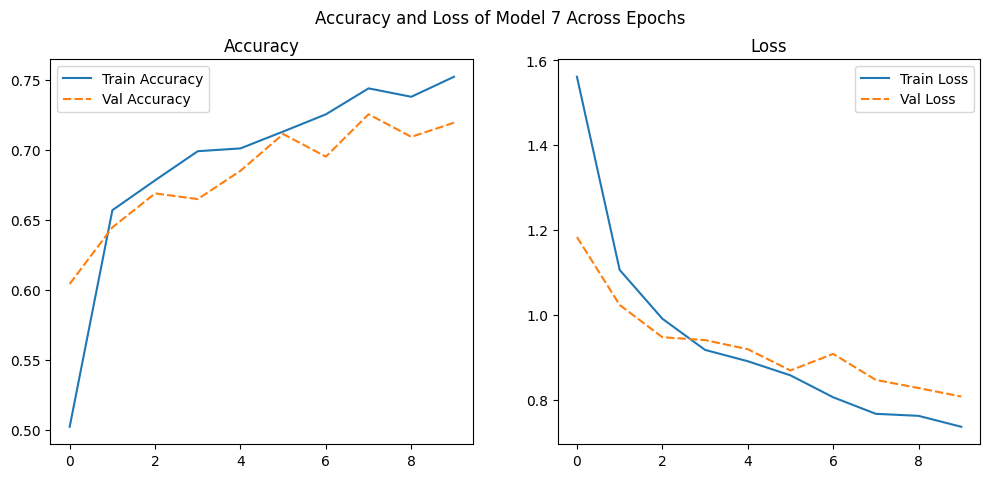

In [ ]:
data_acc_4 = pd.DataFrame({"Train Accuracy": train_accs_4, "Val Accuracy": val_accs_4})
data_loss_4 = pd.DataFrame({"Train Loss": train_losses_4, "Val Loss": val_losses_4})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 4 Across Epochs")

sns.lineplot(data=data_acc_4, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_4, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_4 = pd.concat([data_acc_4, data_loss_4], axis = 1)
result_4

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.502006,0.604040,1.561190,1.183697
1,0.656720,0.644444,1.106191,1.023711
2,0.678034,0.668687,0.991212,0.947576
3,0.698847,0.664646,0.917702,0.940773
4,0.700853,0.684848,0.891048,0.919397
5,0.712889,0.711111,0.857750,0.869253
6,0.725176,0.694949,0.806100,0.908370
7,0.743731,0.725253,0.767100,0.846957
8,0.737713,0.709091,0.762338,0.827840
9,0.752006,0.719192,0.736589,0.807815


In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_4.csv")

## Model 5

- batch_size= 64
- lr = 5e-4
- WD = 1e-5
- DR = 0
- Data Augmentation

In [ ]:
BS = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False
# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 256), # 2048 -> 1024
               nn.BatchNorm1d(256),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(256, 64),
               nn.BatchNorm1d(64),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

               nn.Linear(64, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
# define the loss function
criterion_5 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_5 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=global_WD)

In [ ]:
model_5, train_accs_5, train_losses_5, val_accs_5, val_losses_5 = train_model(model_google, criterion_5, optimizer_5, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.5429 Acc: 0.5479
validation Loss: 1.1448 Acc: 0.6485

Epoch 2/10
----------
training Loss: 0.9808 Acc: 0.7402
validation Loss: 0.8539 Acc: 0.7636

Epoch 3/10
----------
training Loss: 0.7306 Acc: 0.8097
validation Loss: 0.7402 Acc: 0.7758

Epoch 4/10
----------
training Loss: 0.5808 Acc: 0.8433
validation Loss: 0.7044 Acc: 0.7818

Epoch 5/10
----------
training Loss: 0.4617 Acc: 0.8719
validation Loss: 0.6422 Acc: 0.8061

Epoch 6/10
----------
training Loss: 0.3858 Acc: 0.8917
validation Loss: 0.6607 Acc: 0.8020

Epoch 7/10
----------
training Loss: 0.2831 Acc: 0.9235
validation Loss: 0.6638 Acc: 0.7758

Epoch 8/10
----------
training Loss: 0.2553 Acc: 0.9265
validation Loss: 0.6422 Acc: 0.8162

Epoch 9/10
----------
training Loss: 0.2311 Acc: 0.9333
validation Loss: 0.6739 Acc: 0.7960

Epoch 10/10
----------
training Loss: 0.1853 Acc: 0.9483
validation Loss: 0.6778 Acc: 0.7879

Training complete in 34m 48s
Best val Acc: 0.816162


Text(0.5, 1.0, 'Loss')

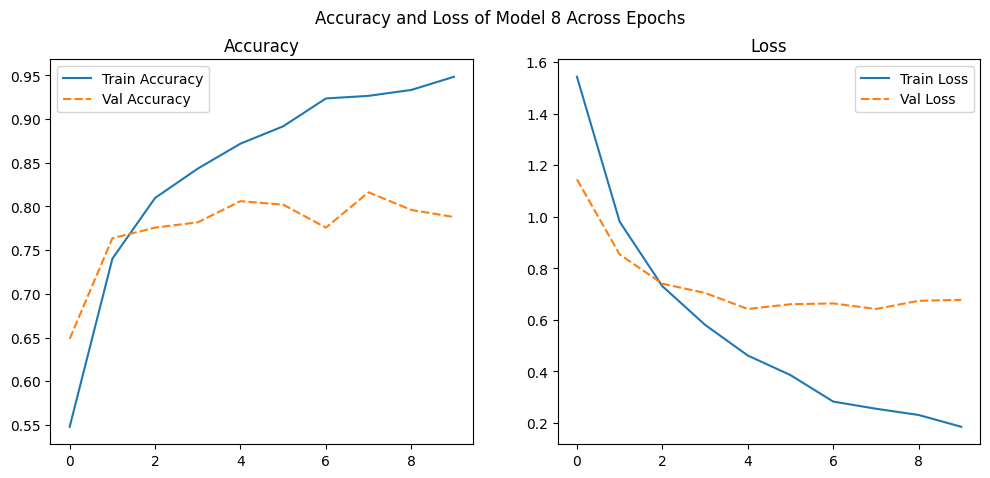

In [ ]:
data_acc_5 = pd.DataFrame({"Train Accuracy": train_accs_5, "Val Accuracy": val_accs_5})
data_loss_5 = pd.DataFrame({"Train Loss": train_losses_5, "Val Loss": val_losses_5})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 5 Across Epochs")

sns.lineplot(data=data_acc_5, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_5, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_5 = pd.concat([data_acc_5, data_loss_5], axis = 1)
result_5

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.547894,0.648485,1.542900,1.144842
1,0.740221,0.763636,0.980776,0.853938
2,0.809679,0.775758,0.730647,0.740237
3,0.843280,0.781818,0.580758,0.704424
4,0.871866,0.806061,0.461687,0.642162
5,0.891675,0.802020,0.385826,0.660689
6,0.923521,0.775758,0.283055,0.663756
7,0.926530,0.816162,0.255337,0.642164
8,0.933300,0.795960,0.231080,0.673884
9,0.948345,0.787879,0.185271,0.677763


In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_5.csv")

In [ ]:
# model_save_name = 'googlenet_final_3.pt'
# path = f"/content/drive/MyDrive/{model_save_name}" 
# torch.save(model_google.state_dict(), path)